In [13]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np

import torch.nn.functional as F
from PIL import Image

from torch import optim
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.datasets import MNIST

In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [4]:
class AttMap(nn.Module):
  
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(AttMap, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes,1)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.conv3(out)

        out = torch.sigmoid(out)

        return out


In [5]:
class testModel(nn.Module):

  def __init__(self, attention = False):
    super(testModel, self).__init__()

    self.attention = attention

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = BasicBlock(64,64)
    self.atten1 = AttMap(64,32)
    self.layer2 = BasicBlock(64,64)
    self.atten2 = AttMap(64,32)
    self.pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(64,10)

    self.atten1Map =0
    self.atten1Map_=0
    self.atten2Map =0
    self.atten2Map_=0

    for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


  def forward(self,x):

    x = (F.relu(self.bn1(self.conv1(x))))

    x = self.layer1(x)
    
    if self.attention:
      y= self.atten1(x)
      self.atten1Map = y
      x = x + x*y
      self.atten1Map_ = x

      
    x = self.layer2(x)

    if self.attention:
      y= self.atten2(x)
      self.atten2Map = y
      x = x + x*y
      self.atten2Map_ = x

    x = self.pooling(x)
    x = x.view(-1, 64)
    x = nn.Softmax()(self.fc(x))


    return x

In [6]:
from torchvision import datasets
from torchvision import transforms

batch_size = 50

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True )

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

In [7]:
device = 'cuda'

criterion = nn.CrossEntropyLoss()

model = testModel(attention = False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
def train(model,epochs,train_loader,optimizer,criterion):

  model.train()
  model = model.train()
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


### Training

#### Model without Attention

In [14]:
model = testModel(attention = False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.train()
train(model,4,train_loader,optimizer,criterion)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.292784
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.976549
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.678085
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.586987
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.518456
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.544765
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.522075
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.495365
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.509186
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.518276
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.473954
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.482965
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.484640
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.467555
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.470167
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.486895
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.472995
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.482073
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.479075
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.479897
Train Epoch: 3 [2000

In [16]:
test(model)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0301, Accuracy: 9678/10000 (97%)



#### Model with Attention

In [17]:
model = testModel(attention = True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
train(model,3,train_loader,optimizer,criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 1.639761
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.495242
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.487287
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.486227
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.531934
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.471654
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.503177
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.465182
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.479340
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.485402
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.478961
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.494953
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.486776
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.483708
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.466293
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.501932
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.478698
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.470734


In [14]:
test(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0299, Accuracy: 9754/10000 (98%)



#### Assigning forward hook for map

In [0]:
maskVal = 0

def copyData(m, inp, out):
  global maskVal
  out1 = out.detach().cpu().numpy()
  maskVal = out1

In [0]:
#hook to return map for attn1
mapHook = list(list(model.children())[3].children())[5].register_forward_hook(copyData)

In [0]:
testData = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [83]:
i = 9
sample = testData[i][0]


out = model(sample.unsqueeze(0).cuda())

maskVal = nn.Sigmoid()(torch.Tensor(maskVal))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


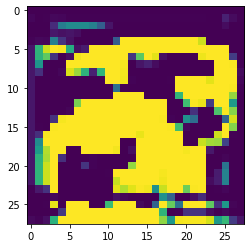

In [84]:
plt.imshow(maskVal[0,0,:,:].cpu().numpy())

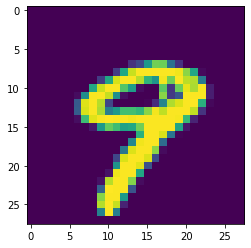

In [85]:
plt.imshow(sample[0].numpy())

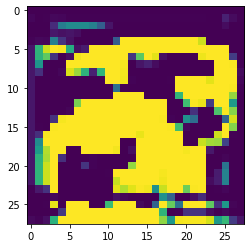

In [86]:
plt.imshow(model.atten1Map[0,0,:,:].detach().cpu().numpy())

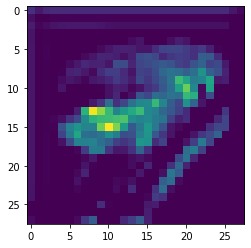

In [87]:
plt.imshow(model.atten1Map_[0,0,:,:].detach().cpu().numpy())

## Altered Data

In [81]:
testData = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))


trainData = datasets.MNIST('../data', train=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [82]:
def getAlteredSample(x):

  blockSize = np.random.randint(20,60)

  block = np.array(Image.fromarray(x[0].numpy()).resize((blockSize,blockSize)))

  imgSize = (100,100)
  blockSize = block.shape

  img = np.ones(imgSize)*-0.4242

  xpos = np.random.randint(0,imgSize[0]-blockSize[0]-1)
  ypos = np.random.randint(0,imgSize[1]-blockSize[1]-1)

  img[xpos : xpos + blockSize[0], ypos : ypos + blockSize[1]] = block

  return img



In [83]:
class AlteredMNIST(torch.utils.data.Dataset):
 

    def __init__(self,dataset):

        self.data = dataset
     

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample,label = self.data[idx]
        sample = getAlteredSample(sample)
        
        sample = transforms.ToTensor()(sample).float()

        
        return sample,label

In [84]:
trainAlterData = AlteredMNIST(trainData)
testAlterData = AlteredMNIST(testData)

batch_size = 80

train_loader = torch.utils.data.DataLoader(
        trainAlterData,
        batch_size=batch_size, shuffle=True )

test_loader = torch.utils.data.DataLoader(
        testAlterData,
        batch_size=batch_size, shuffle=True)

### Training

In [40]:
model = testModel(attention = False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
train(model,4,train_loader,optimizer,criterion)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290374
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.464105
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.462110
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.461576
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.461431
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.461382
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.461281
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.461231


KeyboardInterrupt: 

In [58]:
test(model,test_loader)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0473, Accuracy: 974/10000 (10%)



In [86]:
model = testModel(attention = False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [87]:
train(model,5,train_loader,optimizer,criterion)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301062
Train Epoch: 0 [16000/60000 (27%)]	Loss: 2.110584
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.940921
Train Epoch: 0 [48000/60000 (80%)]	Loss: 1.804793
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.839396
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.857726
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.765292
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.736982
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.720395
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.776332
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.596818
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.667929
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.568069
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.586730
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.581098
Train Epoch: 3 [48000/60000 (80%)]	Loss: 1.644857
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.624745
Train Epoch: 4 [16000/60000 (27%)]	Loss: 1.540407
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.507859
Train Epoch: 4 [48000/60000 (80%)]	Loss: 1.524424


In [88]:
test(model,test_loader)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0293, Accuracy: 1142/10000 (11%)



In [89]:
test(model,train_loader)

/home/santhosr/.conda/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0293, Accuracy: 6937/60000 (12%)



In [90]:
from torchvision.models.resnet import ResNet, BasicBlock

In [91]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(
            super(MnistResNet, self).forward(x), dim=-1)

In [95]:
model = MnistResNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
train(model,5,train_loader,optimizer,criterion)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308944
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.669950
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.556081
Train Epoch: 0 [48000/60000 (80%)]	Loss: 1.552795
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.518126
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.605050
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.507868
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.523019
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.541521
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.487757
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.587193
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.489241
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.526473
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.545880
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.499511
Train Epoch: 3 [48000/60000 (80%)]	Loss: 1.528147
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.504833
Train Epoch: 4 [16000/60000 (27%)]	Loss: 1.498378
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.488059
Train Epoch: 4 [48000/60000 (80%)]	Loss: 1.516719


In [97]:
test(model,test_loader)


Test set: Average loss: 0.0188, Accuracy: 9561/10000 (96%)



In [98]:
test(model,train_loader)


Test set: Average loss: 0.0189, Accuracy: 56798/60000 (95%)



## Random

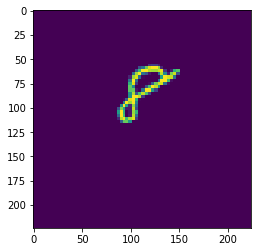

In [28]:
train

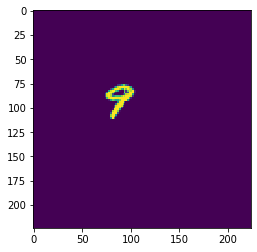

In [105]:
plt.imshow(img)

In [102]:
sample[0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [0]:
class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [0]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

In [0]:
class ResNet18(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1



        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.groups = groups
        self.base_width = width_per_group
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

In [0]:

batch_size = 50

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True )

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

NameError: ignored

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

NameError: ignored

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.ConvTranspose2d(3,10,1)

        

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        return x

In [0]:
net = Net()

In [0]:
a = torch.rand((10,3,10,10))

In [0]:
out = net(a)


In [0]:
w = iter(net.parameters())

In [0]:
a = next(w)

In [0]:
a.shape

torch.Size([3, 10, 1, 1])

In [0]:
for i in net.parameters():
  print(i)

Parameter containing:
tensor([[[[ 0.1243]],

         [[-0.5421]],

         [[ 0.3279]]],


        [[[-0.1762]],

         [[-0.1829]],

         [[-0.3538]]],


        [[[-0.2390]],

         [[-0.5210]],

         [[-0.1505]]],


        [[[ 0.4943]],

         [[ 0.3299]],

         [[ 0.2782]]],


        [[[-0.3986]],

         [[ 0.2170]],

         [[ 0.5023]]],


        [[[-0.1039]],

         [[-0.5375]],

         [[ 0.0492]]],


        [[[-0.2158]],

         [[-0.0592]],

         [[-0.5070]]],


        [[[ 0.5075]],

         [[-0.0797]],

         [[ 0.0920]]],


        [[[ 0.0289]],

         [[ 0.3521]],

         [[-0.4791]]],


        [[[ 0.0140]],

         [[ 0.4927]],

         [[-0.2458]]]], requires_grad=True)
Parameter containing:
tensor([ 0.5756, -0.0097, -0.3002,  0.3459,  0.1772, -0.4801,  0.3421,  0.0394,
         0.1498,  0.4048], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Parameter

In [0]:
sum([np.prod(p.size()) for p in net.parameters()])

512

In [0]:
net.modules

<bound method Module.modules of Net(
  (conv1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>

In [0]:
for i in net.modules():
  print(i.)

AttributeError: ignored

In [0]:
w = iter(net.modules())

In [0]:
q = next(w)

In [0]:
q.parameters

<bound method Module.parameters of Net(
  (conv1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>

In [0]:
q = iter(net.bn1.parameters())

In [0]:
next(q)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [0]:
next(q)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [0]:
next(q)

StopIteration: ignored

In [0]:
a = torch.rand(10,1,5,5)
b = torch.rand(10,6,5,5)


In [0]:
a = np.array(list(range(250)))
b = np.array(list(range(150))*10)

In [0]:
a = np.reshape(a,(10,1,5,5))
b = np.reshape(b,(10,6,5,5))

a = torch.Tensor(a)
b = torch.Tensor(b)

In [0]:
c = a*b

In [0]:
c.shape

torch.Size([10, 6, 5, 5])

In [0]:
testa = a[1,0,:,:]
testa



tensor([[25., 26., 27., 28., 29.],
        [30., 31., 32., 33., 34.],
        [35., 36., 37., 38., 39.],
        [40., 41., 42., 43., 44.],
        [45., 46., 47., 48., 49.]])

In [0]:
testb = b[1,2,:,:]
testb

tensor([[50., 51., 52., 53., 54.],
        [55., 56., 57., 58., 59.],
        [60., 61., 62., 63., 64.],
        [65., 66., 67., 68., 69.],
        [70., 71., 72., 73., 74.]])

In [0]:
testa*testb

tensor([[1250., 1326., 1404., 1484., 1566.],
        [1650., 1736., 1824., 1914., 2006.],
        [2100., 2196., 2294., 2394., 2496.],
        [2600., 2706., 2814., 2924., 3036.],
        [3150., 3266., 3384., 3504., 3626.]])

In [0]:
c[1,2,:,:]

tensor([[1250., 1326., 1404., 1484., 1566.],
        [1650., 1736., 1824., 1914., 2006.],
        [2100., 2196., 2294., 2394., 2496.],
        [2600., 2706., 2814., 2924., 3036.],
        [3150., 3266., 3384., 3504., 3626.]])

## FB Test

In [0]:
import pandas as pd
import numpy as np
import random

In [0]:
dates = ['2012-10-01','2012-10-02','2012-10-03','2012-10-04','2012-10-05']

studentIds = list(range(1,21))

attendData = []

for i in dates:
  for j in studentIds:
    attendData.append([i,j,random.randint(0,1)])

attendDf = pd.DataFrame(attendData)
attendDf.columns = ['date','studentID','attend']

attendDf.date = pd.to_datetime(attendDf.date)

In [0]:
attendDf.head()

,date,studentID,attend
0,2012-10-01,1,1
1,2012-10-01,2,1
2,2012-10-01,3,0
3,2012-10-01,4,0
4,2012-10-01,5,1


In [0]:
studentData = []

for i in studentIds:
  studentData.append([i, random.randint(1,3)])

studentDf = pd.DataFrame(studentData)
studentDf.columns = ['studentID','grade']

In [0]:
studentDf.head()

,studentID,grade
0,1,3
1,2,1
2,3,2
3,4,1
4,5,3


In [0]:
df = pd.merge(attendDf, studentDf, on='studentID',how='left')

In [0]:
df.head()

,date,studentID,attend,grade
0,2012-10-01,1,1,3
1,2012-10-01,2,1,1
2,2012-10-01,3,0,2
3,2012-10-01,4,0,1
4,2012-10-01,5,1,3


In [0]:
d = df.groupby(['date','grade'])['attend'].mean().reset_index()


In [0]:
d = d.reset_index()

In [0]:
d['lastAttend'] = d.groupby('grade')['attend'].shift(1)
d['attendDiff'] = d.lastAttend - d.attend

In [0]:
d.head()

,date,grade,attend,lastAttend,attendDiff
0,2012-10-01,1,0.625,NaN,NaN
1,2012-10-01,2,0.750,NaN,NaN
2,2012-10-01,3,0.500,NaN,NaN
3,2012-10-02,1,0.750,0.625,-0.125
4,2012-10-02,2,0.500,0.750,0.250


In [0]:
w = d[d.grade==1]

In [0]:
w.attend.shift(1)

0       NaN
3     0.625
6     0.750
9     0.375
12    0.625
Name: attend, dtype: float64

In [0]:
def getShift(x):

  x = x.sort_values('date')
  x['LastAttend'] = x.attend.shift(1)
  x['attendDiff'] = x.attend - x.LastAttend

  return x[['date','attendDiff']]

In [0]:
out = d.groupby('grade').apply(getShift)

In [0]:

out = out.reset_index()

In [0]:

out[out.date == pd.to_datetime('2012-10-03')]

,grade,level_1,date,attendDiff
2,1,6,2012-10-03,-0.375
7,2,7,2012-10-03,-0.250
12,3,8,2012-10-03,-0.500


In [0]:
d

,date,grade,attend
0,2012-10-01,1,0.625
1,2012-10-01,2,0.750
2,2012-10-01,3,0.500
3,2012-10-02,1,0.750
4,2012-10-02,2,0.500
5,2012-10-02,3,0.875
6,2012-10-03,1,0.375
7,2012-10-03,2,0.250
8,2012-10-03,3,0.375
9,2012-10-04,1,0.625
